# Analis de datos sobre tematica COVID 

# Abstract 

##### La idea de esta notebook es evaluar y poder predecir por cada pais los contagios y las muertes obsercando del data set datos como pueden llegar a ser los casos ya activos el ratio de reproduccion del virus la poblacion de cada pais, el porcetaje de la poblacion que es mayor de edad o factor de riesgo etc, y ver como esto impacta en lo antes mecionado. El data frame tambien cuneta con informacion relevante en cuanto a las instalaciones santirias de los paises como pueden ser las camas diponibles y ocupadas de terapia intesiva, la cantidad de la poblacion con acceso a intalacions basicas de higiene, todo esto lo cual puede llegar a ser relevante al momento de ver el comportamiento del virus en el tiempo.

# Contexto Analitico

##### para llevar a cabo nuestro analisi contamos con un data set obtenido por la pagina keaggle pero que tambien cuenta con un repositorio de github donde se encuentra mejor explicado y con todas sus fuentes de informacion (https://github.com/owid/covid-19-data/tree/master/public/data)

# Objetivo

##### El objetivo principal de este notebook es poder armar un modelo que pueda predecir con un minimo de exactitud los nuevos casos que se puedan dar asi como tambien las nuevas muertes para esto resumidamente haremos lo siguente:

##### En primer lugar importaremos las librerias que usaremos durate el desarrolo del proyecto.

##### Luego comenzaremos con un analisis exploratorio de los datos, donde se intentara mostrar informacion relevante del data set, donde tambien moldearemos un poco la base da datos para que no sea tan extenso. 

##### En tercer instacia comezaremos ahora si con el Data Wrangling aplicando metodos de Featured Selection para la eliminacion de outliers y para luego poder generar los modelos.

##### Continuaremos con la creacion de los modelos con los resultados obtenidos en la instacia anterior selccioncionado tambien cual de todas las features selection antes relizadas funcioa mejor con nuestra informacion.

# Preguntas

##### El dataframe (df de ahora en adelante) proporciona como mencione antes varias instalaciones "sanitarias" que tiene el pais, una de las prguntas que nos podemos hacer en base a esto es ver que tanto influye o influyo que cada pais tenga o no estas instalaciones en el crecimiento o decrecimiento de los casos. 

##### Tambien el df porporcina informacion sobre las vacunaciones, teniendo en cuenta esto podemos ver la influencia de las vacunaciones en los casos nuevos, pero principalmente nos interesa ver que modificacion genero en las nuevas muertes, ya que el objetivo final de la vacuna no es evitar el contagio sino evitar la muerte.

##### Tambien contamos con datos como puede ser el *stringency_index* que es basicamente como el pais responde en base al progreso del virus generando cuarentenas o prohibiendo ciertas avtividades como pueden ser la presencialidad en los colegios, con esta data podemos ver si la "cuarentena" fue realmente efectiva en ciertos casos. 

##### Respondiendo estas y otras preguntas que se generan mas adelante intentaremos predecir no solo los nuevos casos sino tambien las nuevas muertes que se pueden llegar a generar a causa del virus.


# 1.1 Importacion de librerias


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from   scipy import stats
import statsmodels.formula.api as sm
import chart_studio.plotly     as py
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
import pingouin
from IPython.display import display
from ipywidgets import Dropdown
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

### 1.2 Carga del dataset con pandas

In [3]:
df = pd.read_csv("..\DataSets\owid-covid-data.csv")
df['Porcentaje_contagios'] = (df['total_cases'] / df['population']) * 100
df.shape
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# 2 Analisis Exploratorio de Datos (EDA)

# 2.1 limpieza de la base datos (Data Wrangling)
##### Elimino algunas colunmas que no voy a estar usando para el analisis junto con los valores tipo Nan que pueden entorpecer tanto las graficas como los datos luego

In [55]:
#reemplazo de los string NaN por el nan de numpy.
df.replace('NaN',np.nan,inplace= True)

df.replace('0',np.nan,inplace=True)

##### Ahora vamos a tomar nuestro df y voy a analizar en cada colunma de interes si estos tiene al menos el 60% de los datos no nulos, si el pais tiene alguna de estas colunmas de interes con menos del 60% de datos voy a excluir ese pais del analisis ya que no tiene una buena base para poder hacer el analisis

In [56]:
df = df.drop(['total_cases_per_million','new_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million', 'new_deaths_per_million','new_deaths_smoothed_per_million','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million','weekly_hosp_admissions_per_million','total_tests_per_thousand','new_tests_per_thousand','new_tests_smoothed_per_thousand','total_vaccinations_per_hundred', 'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','new_people_vaccinated_smoothed_per_hundred'],axis=1)
pais = df['location'].unique().tolist()
paises_a_descartar =[]
colunmas_de_interes = ['total_cases','total_deaths','stringency_index','total_vaccinations','people_vaccinated','people_fully_vaccinated','hosp_patients','population','total_tests', 'new_tests']

for location in pais:
          df_target = df[(df['location'] == location)]
          #print(df_target.shape)
          filas = df_target.shape[0]
          #print(filas)
          df_missing_data = df_target.isnull()
          #missing_data.head()
          #print(location)
          for column in df_missing_data.columns.values.tolist():
                    conteo = df_missing_data[column].value_counts()                                        
                    if filas-conteo[0] > filas*0.4:  # conteo[0] indica la cantidad de valores que existen en esa columna que no son nulos 
                              if column in colunmas_de_interes:                
                                        paises_a_descartar.append(location)
                              
df_a_descartar = pd.DataFrame(paises_a_descartar)

valores_a_eliminar = df_a_descartar[0].unique().tolist()
                              

In [57]:

# eliminacion de filas que contiene valores nulos de colunmas importantes.
#df = df.dropna(subset=['total_cases','total_deaths','stringency_index','total_vaccinations','people_vaccinated','people_fully_vaccinated','hosp_patients','population','total_tests', 'new_tests',])
# eliminaciond e colunmas que no resultan importates para la evalaucion de los datos.
df = df.drop(['total_cases_per_million','new_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million', 'new_deaths_per_million','new_deaths_smoothed_per_million','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million','weekly_hosp_admissions_per_million','total_tests_per_thousand','new_tests_per_thousand','new_tests_smoothed_per_thousand','total_vaccinations_per_hundred', 'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','new_people_vaccinated_smoothed_per_hundred'],axis=1)
#df.dtypes
df = df.drop(df[df['location'].isin(valores_a_eliminar)].index)
df



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Porcentaje_contagios
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219413,ZMB,Africa,Zambia,9/26/2022,333439.0,0.0,7.429,4017.0,0.0,0.0,...,24.7,13.938,2.0,63.89,0.584,NaN,NaN,NaN,NaN,1.712303
219414,ZMB,Africa,Zambia,9/27/2022,333503.0,64.0,16.571,4017.0,0.0,0.0,...,24.7,13.938,2.0,63.89,0.584,NaN,NaN,NaN,NaN,1.712632
219415,ZMB,Africa,Zambia,9/28/2022,333503.0,0.0,9.143,4017.0,0.0,0.0,...,24.7,13.938,2.0,63.89,0.584,NaN,NaN,NaN,NaN,1.712632
219416,ZMB,Africa,Zambia,9/29/2022,333531.0,28.0,13.143,4017.0,0.0,0.0,...,24.7,13.938,2.0,63.89,0.584,NaN,NaN,NaN,NaN,1.712776


### 2.2 Dentro de las colunmas que mas nos interesan estan las siguientes

- *Continent* : continete al cual pertenecen los paises a analizar
- *Location* : nombre del pais 
- *Date* : fecha en la cual se recabaron los datos 
- *total_cases* : acumulado de casos hasta el dia de la fecha 
- *new_cases* : nuevos casos en un dia dado
- *total_death* : muertes acumuladas hasta el dia de la fecha 
- *new_death* : nuevas muertes en un dia dado
- *icu_patients* : cantidad de pacientes en Terapia intesiva en un dia dado 
- *hosp_patients* : catidad de pacientes en hospital en un dia dado 
- *weekly_icu_admissions* : cantidad de ingresados en terapia intesiva en una semana dada
- *weekly_hosp_admissions* : catidad de pacientes ingresados en el hospital en una semana dada
- *stringency_index* : idice de rigurosiad de la respuesta del gobierno(cierre de escuelas, prohibicion de viajes,etc) escalado a un valor en tre 0 y 100 siendo 100 la repuesta mas stricta.
- *reporduction_rate* : ratio de reprodccion del virus 
- *totaL_test* : cantidad acumulada de testeos
- *new_test* :  nuevos testeos realizados en un dia dado
- *positive_rate* : porcentaje de los testeos realizado que resultaron positivos.
- *total_vaccinations* : cantidad total de dosis de vacunacion aplicadas
- *people_vaccionations* : total de personas que recibieron al menos una dosis de la vacuna 
- *people_fully_vaccinated* : cantidad total de personas que recibieron todas las dosis de la vacuna
- *total_booster* :  catidad de refuerzo de vacuna que fueron aplicados
- *new_vaccinations* : catidad nueva de dosis aplicadas en un dia dado
- *population* : ultimo dato disponible de la poblacion de cada pais al momento de la toma de la muestra.
- *population_density* : desidad poblacional
- *handwashing_facilities* : parte de la poblacion que posee intalaciones basicas para higine personal. 



### 2.3 Ordenamiento de la base de datos 

In [58]:
# copia de la base de datos
copy_df = df.copy()

#convierto la coluna de fechas al formato de fecha 
copy_df['date'] = pd.to_datetime(copy_df['date'])

# Agrupar por paises continentes y paises
continentes = copy_df.groupby("continent")

# Separo por continente 

copy_df = copy_df.query('location in ["United States"]')

paises = copy_df.groupby("location")
#paises.size()


###

# 2.4 Grafico de Nuevos casos vs indice de restriccion

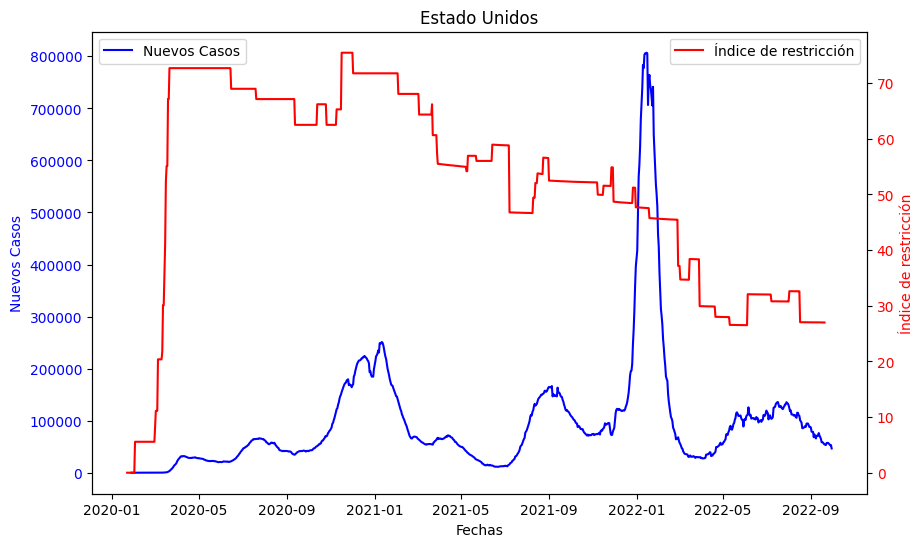

In [61]:
pais_df = copy_df[copy_df['location'] == 'United States']

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

# Graficar el primer conjunto de datos (nuevos casos)
ax.plot(pais_df['date'], pais_df['new_cases_smoothed'], color='blue', label='Nuevos Casos')
# Graficar el segundo conjunto de datos (Índice de restricción)
ax2.plot(pais_df['date'], pais_df['stringency_index'], color='red', label='Índice de restricción')

ax.set_ylabel('Nuevos Casos', color='blue')
ax2.set_ylabel('Índice de restricción', color='red')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
ax.set_title('Estado Unidos')
ax.set_xlabel('Fechas')

# Agregar leyenda y mostrar el gráfico
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

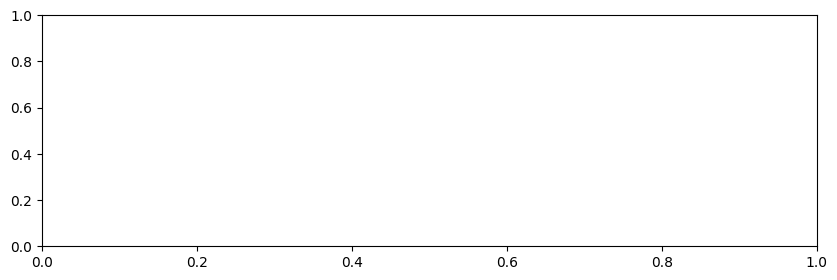

In [59]:
fig, axs = plt.subplots(nrows=len(copy_df['location'].unique()), figsize=(10, 3*len(copy_df['location'].unique())))
plt.subplots_adjust(hspace=0.5)

# Iterar sobre cada país y crear un gráfico separado para cada uno
for i, (pais, grupo) in enumerate(paises):
    ax1 = axs[i]
    ax2 = ax1.twinx()

    # Graficar el primer conjunto de datos (nuevos casos)
    ax1.plot(grupo['date'], grupo['new_cases_smoothed'], color='blue', label='Nuevos Casos')
    # Graficar el segundo conjunto de datos (Índice de restricción)
    ax2.plot(grupo['date'], grupo['stringency_index'], color='red', label='Índice de restricción')
    
    ax1.set_ylabel('Nuevos Casos', color='blue')
    ax2.set_ylabel('Índice de restricción', color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.set_title(pais)
    ax1.set_xlabel('Fechas')

    # Agregar leyenda y mostrar el gráfico
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
plt.show()

### Analisis de las graficas

Podemos notar en estas graficas que usuamente al bajar el indice de reestriccion en cada pais se pueden notar incrementos en los casos nuevos, con esto a simple vista podemos llegar a intuir que las restricciones aplicadas por pais si dan resultado, pero esta tambien es una primera instacia de analisis quedan muchos datos mas por analizar a lo largo del proyecto.

# 2.5 Grafico de nuevas muertes por pais 


In [ ]:
#for i, (name, group) in enumerate(paises):
#   color = (random.random(), random.random(), random.random());
#   group.plot(x='date', y='total_deaths', label=name, color = color,figsize=(10,6))
#   plt.xlabel('Fecha')
#   plt.ylabel('Cant Muertes')


#plt.legend()
#plt.show()



### Analisis

##### En estos graficos podemos ver las nuevas muertes por dia en cada pais

## 2.6 Grafico de maximos de testeos por pais 

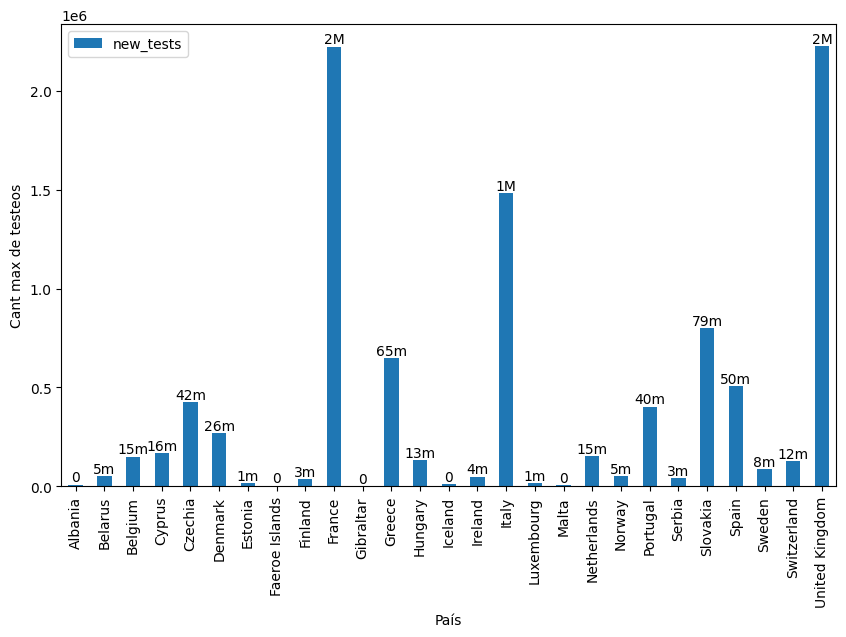

In [ ]:

## excluyo los paises que no tiene datos de los nuevos testeos 
#df2 = copy_df.dropna(subset=['new_tests'])

#df_grouped = df2.groupby('location').max()

#df_grouped.plot(kind='bar', y='new_tests',figsize=(10,6))
#plt.xlabel('País')
#plt.ylabel('Cant max de testeos')



df2 = copy_df.dropna(subset=['new_tests'])
df_grouped = df2.groupby('location').max()
ax = df_grouped.plot(kind='bar', y='new_tests',figsize=(10,6))
plt.xlabel('País')
plt.ylabel('Cant max de testeos')

# Función para formatear los valores de las etiquetas
def millions_format(x):
          if (x >1000000):
                    return f'{int(x/1000000)}M'
          elif(0 < x >1000000):
                    return f'{int(x/10000)}m'
          elif(0<x>10000):
                    return f'{int(x/10000)}m'
          else:
                    return f'{0}'

# Iteramos sobre las barras para agregar las etiquetas
for i in ax.containers:
    values = i.datavalues
    labels = [millions_format(value) for value in values]
    ax.bar_label(i, labels=labels, label_type='edge', fontsize=10)

plt.show()




En esta grafica podemos ver el maximo de testeos en un dia por pais en Europa

## 2.7 Box Plot 
 #### sobre los nuevos casos por dia 

Text(0.5, 1.0, 'Nuevos casos')

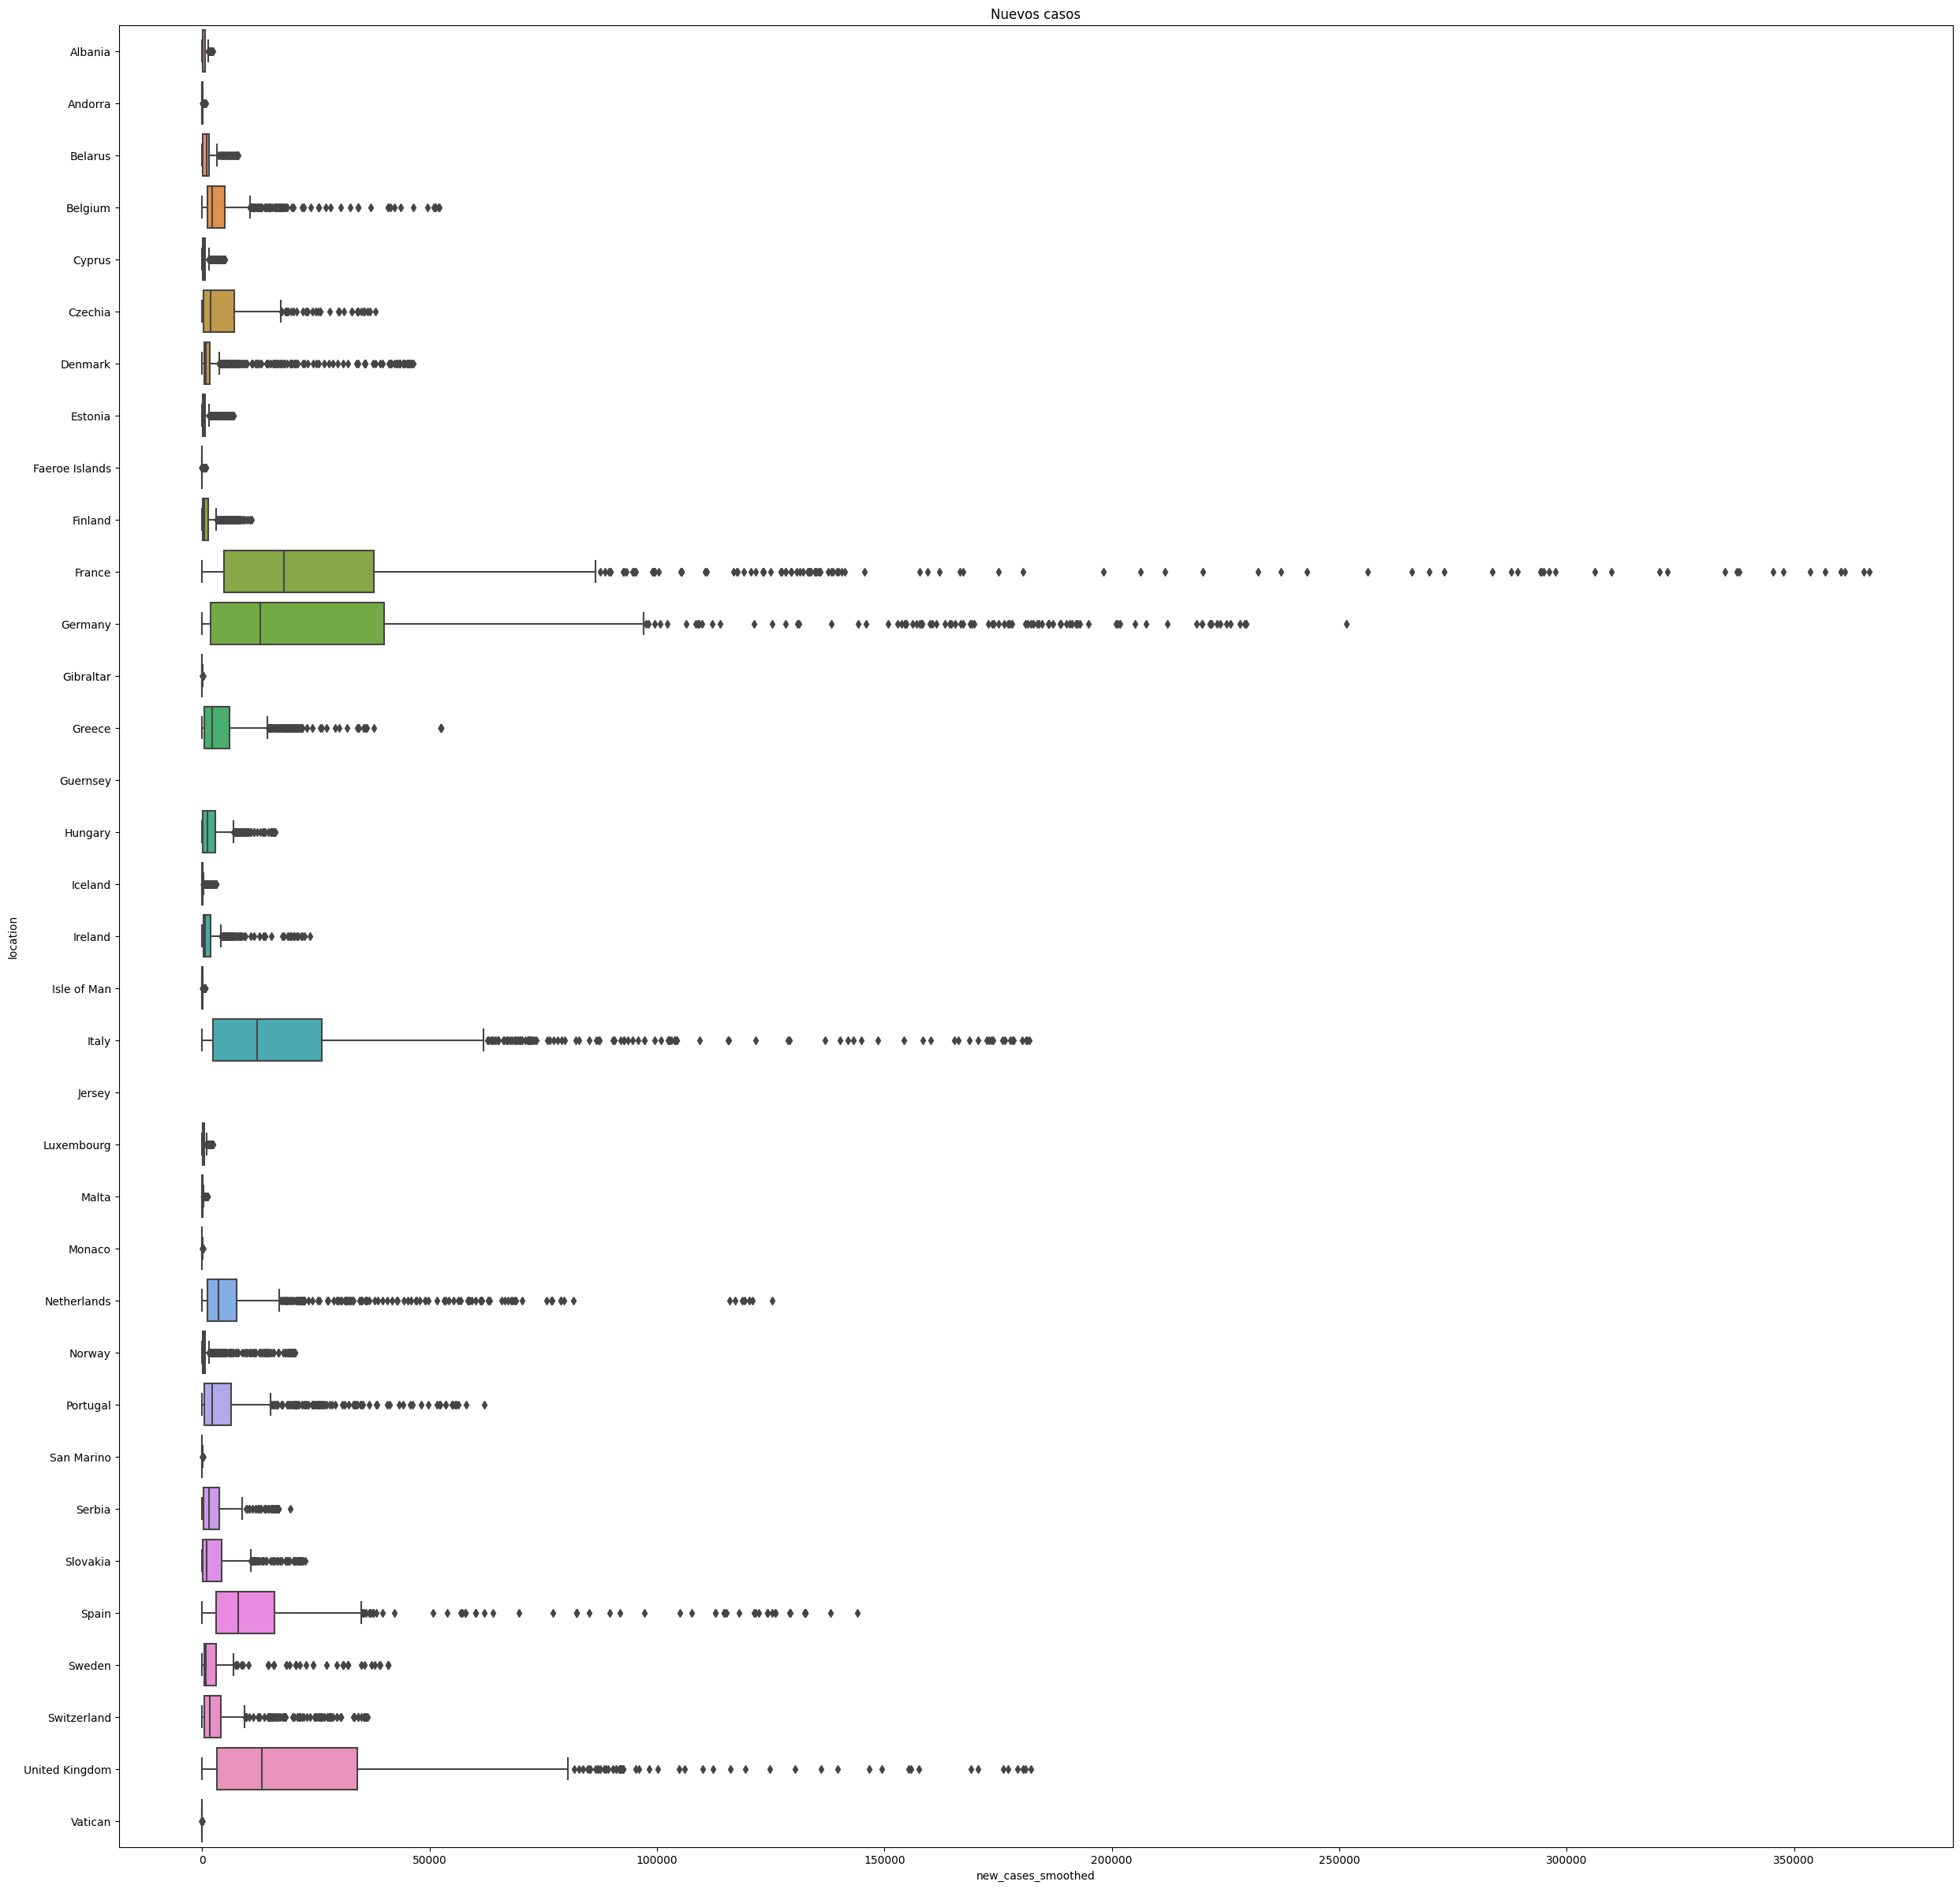

In [ ]:
df_grouped = copy_df.groupby('location')

plt.figure(figsize=[30,30])

sns.boxplot(y='location',x='new_cases_smoothed', data=copy_df,)
plt.title('Nuevos casos')

# 2.8 Grafico barras de total de vacunados por pais


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_10912\2989198453.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_grouped = df3.groupby('location').max()


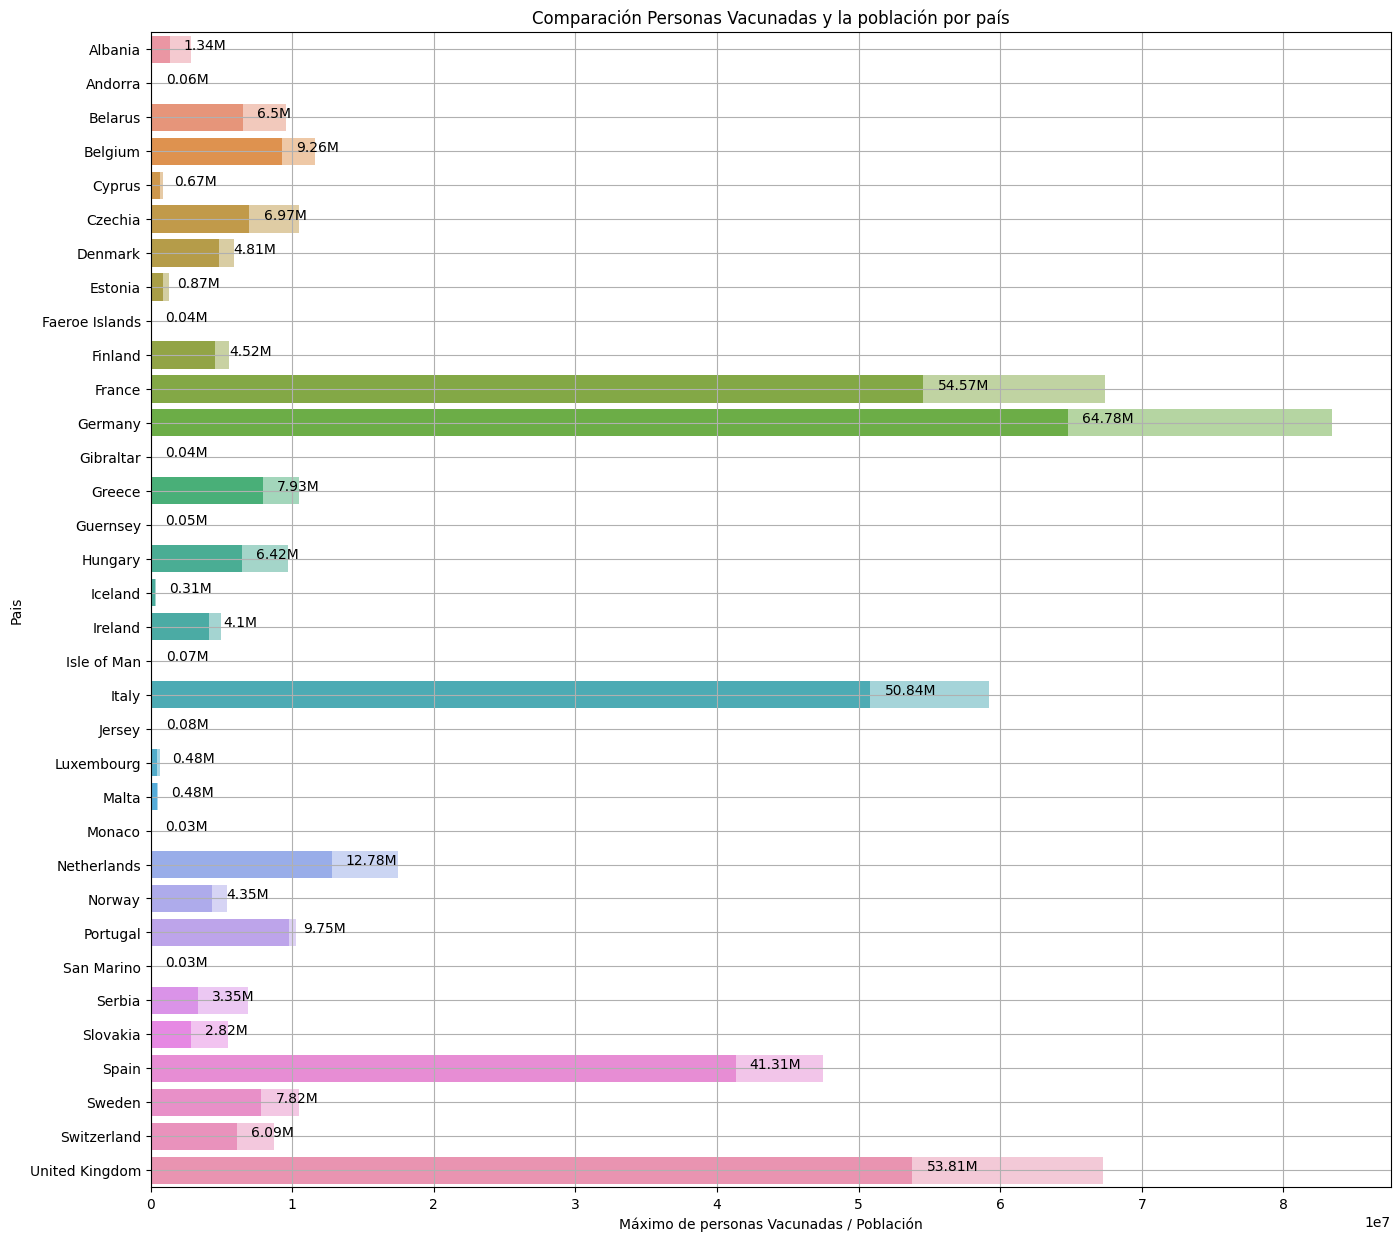

In [ ]:
df3 = copy_df.dropna(subset=["people_vaccinated"])

plt.figure(figsize=(16,15))
df_grouped = df3.groupby('location').max()

ax = sns.barplot(y=df_grouped.index, x='population', data=df_grouped,  alpha = 0.5)

#sns.barplot(y=df_grouped.index, x='population', data=df_grouped,  alpha = 0.5)
sns.barplot(y=df_grouped.index, x='people_vaccinated', data=df_grouped )

for i, value in enumerate(df_grouped['people_vaccinated']):
    ax.annotate(f'{round(float(value/1000000),2)}M', (value+1000000, i), ha='left', fontsize=10)

plt.grid()
plt.xlabel('Máximo de personas Vacunadas / Población')
plt.ylabel('Pais')
plt.title('Comparación Personas Vacunadas y la población por país')
plt.show()

En este grafico podemos ver la comparativa entre el total de personas vacunadas y el total de la poblacion del los paises. Siendo los valores impresos las personas vacunadas por pais. con esto ponemos tener una visual rapida de que porcetaje hay en cada pais de personas vacunadas. 

# 2.9 Grafico de ingresos al hopital vs ingresos a terapia intesiva



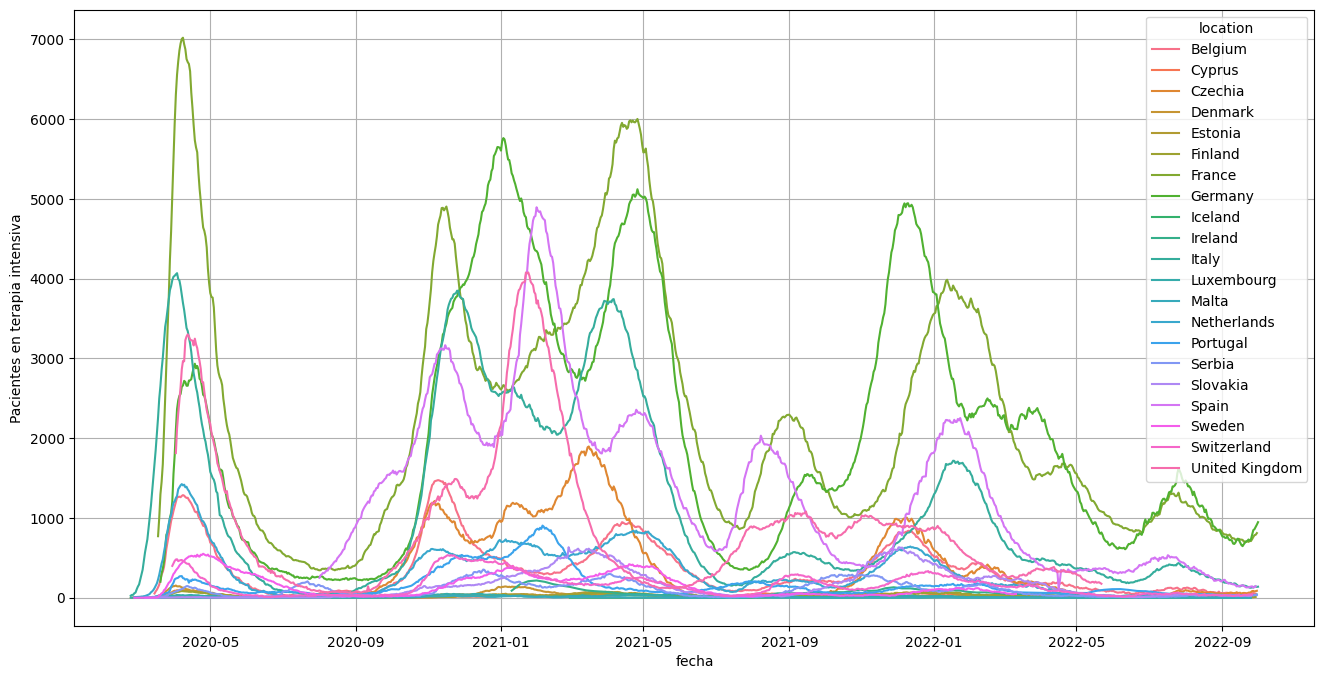

In [ ]:
df3 = copy_df.dropna(subset=["icu_patients"])
#df4 = copy_df.dropna(subset=["hosp_patients"])

plt.figure(figsize=(16,8))


#sns.lineplot(x=df4['date'], y='hosp_patients', data=df4,hue='location')
sns.lineplot(x=df3['date'], y='icu_patients', data=df3, hue='location')
plt.grid()
plt.xlabel('fecha')
plt.ylabel('Pacientes en terapia intensiva')
plt.title('')
plt.show()
#df3

Este grafico muestrs por fecha la cantidad de pacientes que ingresaron a la terapia intesiva por pais 

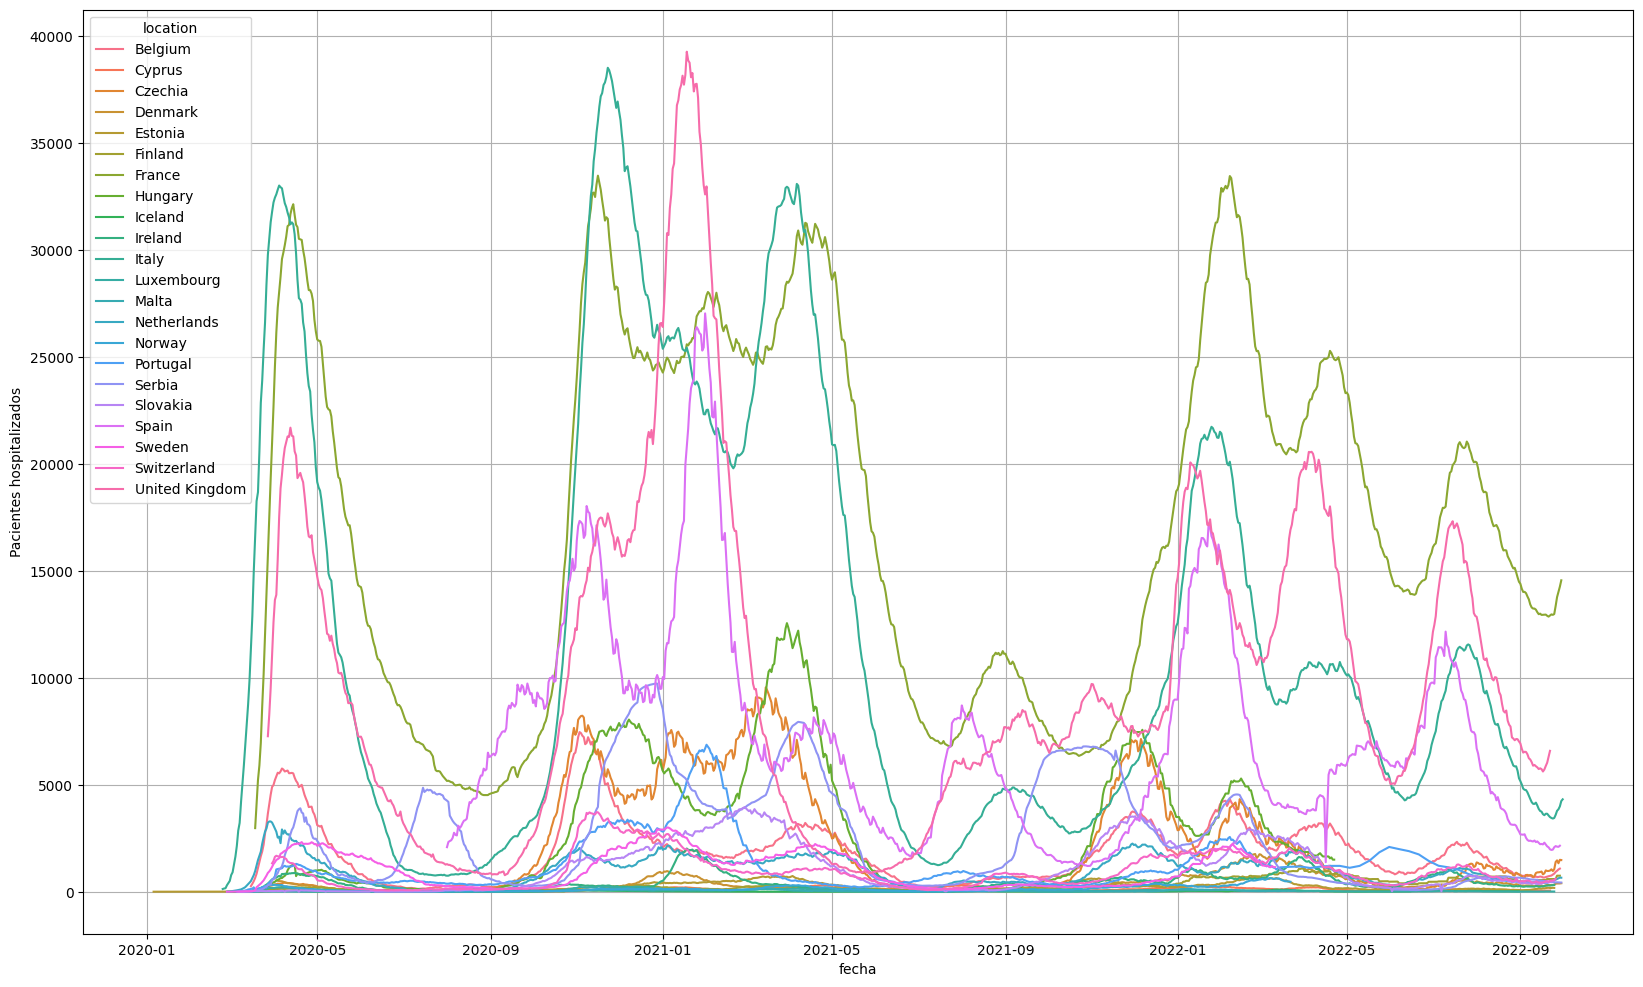

In [ ]:
#df3 = copy_df.dropna(subset=["icu_patients"])
df4 = copy_df.dropna(subset=["hosp_patients"])

plt.figure(figsize=(20,12))


sns.lineplot(x=df4['date'], y='hosp_patients', data=df4,hue='location')
#sns.lineplot(x=df3['date'], y='icu_patients', data=df3, hue='location')
plt.grid()
plt.xlabel('fecha')
plt.ylabel('Pacientes hospitalizados')
plt.title('')
plt.show()
#df3

Este grafico es similar al anterior pero muestra las personas que fueron solamente hospitalizadas

# 3.1 Featured Selection 


## 3.2 Definicion de las funciones a utilizar

In [ ]:
import statsmodels.api as sm1

#foward selection

def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist() # lista con columnas
    best_features = [] # lista vacia para guardar features significativos
    while (len(initial_features)>0): # siempre y cuando esto sea mayor que 0 seguir
        remaining_features = list(set(initial_features)-set(best_features)) # operacion diferencia todas - features que van saliendo
        new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
        for new_column in remaining_features: # para las columnas restates seguir evaluando
            model = sm1.OLS(target, sm1.add_constant(data[best_features+[new_column]])).fit() # ajustar el modelo con target agregando columnas de una en una
            new_pval[new_column] = model.pvalues[new_column] # agregar a la serie el p valor para cada feature
        min_p_value = new_pval.min() # encontrar el p valor minimo (mas significativo)
        if(min_p_value<significance_level): # verificar si es menor a alpha
            best_features.append(new_pval.idxmin()) # agregar el nombre del feature
        else:
            break # cuando no se cumpla la condicion parar y salir
    return best_features

#Bidireccional

def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm1.OLS(target, sm1.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm1.add_constant(data[best_features])
                p_values = sm1.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

#backward 

def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist() # arrancamos con todas las columnas
    while(len(features)>0): # siempre y cuando haya mas de 1 feature seguir
        features_with_constant = sm1.add_constant(data[features]) # hacer el modelo con todas las variables e ir removiendo
        p_values = sm1.OLS(target, features_with_constant).fit().pvalues[1:] # ajustar el modelo y sacar p valores
        max_p_value = p_values.max() # sacar el p valor maximo
        if(max_p_value >= significance_level): # verificar si es mayor a la significancia
            excluded_feature = p_values.idxmax() # de ser asi remover el feature por ser no significativo
            features.remove(excluded_feature) # remover de la lista de fetures
        else:
            break 
    return features




In [ ]:
# sacar de la base de datos la colunma objetivo y se pararlar 
copy_df = df.copy()

copy_df.fillna(0,inplace=True)

X = copy_df.drop(['new_cases','new_cases_smoothed','iso_code', 'continent', 'location', 'date','tests_units'], axis=1)
Y= copy_df['new_cases']

In [ ]:
import numpy as np
from scipy import stats
# IQR
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1
X_r= X.copy()
X_r['outlier_iqr'] = X_r.apply(lambda row: 1 if any(np.abs(row - q3) > 1.5*iqr) else 0, axis=1)
# Tukey
med = X.median()
X_r['outlier_tukey']=X_r.drop(columns='outlier_iqr').apply(lambda row: 1 if any(np.abs(row - med) > 1.5*iqr) else 0, axis=1)
X_r

,total_cases,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,total_tests,...,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Porcentaje_contagios,outlier_iqr,outlier_tukey
0,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.5,64.83,0.511,0.0,0.0,0.0,0.0,0.000012,1,1
1,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.5,64.83,0.511,0.0,0.0,0.0,0.0,0.000012,1,1
2,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.5,64.83,0.511,0.0,0.0,0.0,0.0,0.000012,1,1
3,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.5,64.83,0.511,0.0,0.0,0.0,0.0,0.000012,1,1
4,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.5,64.83,0.511,0.0,0.0,0.0,0.0,0.000012,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219413,333439.0,4017.0,0.0,0.0,0.86,0.0,0.0,0.0,0.0,0.0,...,2.0,63.89,0.584,0.0,0.0,0.0,0.0,1.712303,1,1
219414,333503.0,4017.0,0.0,0.0,0.89,0.0,0.0,0.0,0.0,0.0,...,2.0,63.89,0.584,0.0,0.0,0.0,0.0,1.712632,1,1
219415,333503.0,4017.0,0.0,0.0,0.88,0.0,0.0,0.0,0.0,0.0,...,2.0,63.89,0.584,0.0,0.0,0.0,0.0,1.712632,1,1
219416,333531.0,4017.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,2.0,63.89,0.584,0.0,0.0,0.0,0.0,1.712776,1,1


In [ ]:
X_r['outlier_iqr'].value_counts()

1    145822
0     11977
Name: outlier_iqr, dtype: int64

In [ ]:
X_r['outlier_tukey'].value_counts()

1    149551
0      8248
Name: outlier_tukey, dtype: int64

In [ ]:
X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))]
indexes=X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))].index

In [ ]:
X_n= X.loc[indexes]
y_n= Y.loc[indexes]

In [ ]:
y_n.shape

(12757,)

In [ ]:
X_n.shape

(12757, 42)

# 4.1 Modelos

In [ ]:
import warnings #new cases
warnings.filterwarnings("ignore")
forward_selection(X_n,y_n)

['new_deaths',
 'total_cases',
 'new_deaths_smoothed',
 'aged_70_older',
 'reproduction_rate',
 'handwashing_facilities',
 'diabetes_prevalence',
 'new_people_vaccinated_smoothed',
 'aged_65_older',
 'male_smokers',
 'life_expectancy',
 'female_smokers',
 'positive_rate',
 'Porcentaje_contagios',
 'population',
 'median_age',
 'hospital_beds_per_thousand']

In [ ]:
modelE  = 'new_cases_smoothed~ + total_boosters + weekly_hosp_admissions  + icu_patients + new_deaths + new_deaths_smoothed + new_tests + positive_rate + population + population_density  + people_fully_vaccinated + aged_65_older + total_tests + hospital_beds_per_thousand +  diabetes_prevalence + diabetes_prevalence + extreme_poverty + new_vaccinations + median_age + total_vaccinations+ new_vaccinations_smoothed + people_vaccinated + female_smokers '

lmE = sm.ols(formula=modelE , data= copy_df)

result = lmE.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 1.342e+04
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        15:26:09   Log-Likelihood:            -1.9537e+06
No. Observations:              157799   AIC:                         3.908e+06
Df Residuals:                  157777   BIC:                         3.908e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
warnings.filterwarnings("ignore") #new cases
backward_elimination(X_n,y_n)

['total_cases',
 'new_deaths',
 'new_deaths_smoothed',
 'reproduction_rate',
 'icu_patients',
 'hosp_patients',
 'weekly_icu_admissions',
 'weekly_hosp_admissions',
 'positive_rate',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_people_vaccinated_smoothed',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'diabetes_prevalence',
 'male_smokers',
 'handwashing_facilities',
 'life_expectancy',
 'excess_mortality_cumulative_absolute',
 'excess_mortality_cumulative',
 'excess_mortality',
 'excess_mortality_cumulative_per_million',
 'Porcentaje_contagios']

In [ ]:
modelE  = 'new_cases_smoothed~ total_cases + total_deaths + new_deaths + new_deaths_smoothed + icu_patients + hosp_patients + weekly_hosp_admissions + total_tests + new_tests + positive_rate + total_vaccinations + people_vaccinated + total_boosters + new_vaccinations + new_vaccinations_smoothed + stringency_index + population + population_density + aged_70_older + cardiovasc_death_rate + female_smokers + male_smokers + handwashing_facilities + hospital_beds_per_thousand + excess_mortality_cumulative_absolute + excess_mortality_cumulative + excess_mortality + excess_mortality_cumulative_per_million '

lmE = sm.ols(formula=modelE , data= copy_df)

result = lmE.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        15:26:10   Log-Likelihood:            -1.9460e+06
No. Observations:              157799   AIC:                         3.892e+06
Df Residuals:                  157770   BIC:                         3.892e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
warnings.filterwarnings("ignore") #new cases
stepwise_selection(X_n,y_n) 

['new_deaths',
 'total_cases',
 'new_deaths_smoothed',
 'aged_70_older',
 'reproduction_rate',
 'handwashing_facilities',
 'diabetes_prevalence',
 'new_people_vaccinated_smoothed',
 'aged_65_older',
 'male_smokers',
 'life_expectancy',
 'positive_rate',
 'Porcentaje_contagios',
 'population',
 'median_age',
 'gdp_per_capita',
 'population_density',
 'extreme_poverty']

In [ ]:
modelE  = 'new_cases_smoothed~ weekly_hosp_admissions + icu_patients + new_deaths + new_deaths_smoothed + new_tests + positive_rate + population_density + total_cases + people_fully_vaccinated + aged_65_older + median_age + extreme_poverty + total_tests + Porcentaje_contagios + diabetes_prevalence + new_tests_smoothed + total_vaccinations + new_vaccinations_smoothed + new_vaccinations + total_boosters + tests_per_case + reproduction_rate + people_vaccinated + life_expectancy'
lmE = sm.ols(formula=modelE , data= copy_df)

result = lmE.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                 1.379e+04
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        15:26:17   Log-Likelihood:            -1.9454e+06
No. Observations:              157799   AIC:                         3.891e+06
Df Residuals:                  157774   BIC:                         3.891e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Revisando la los modelos parace ser que realizando una backward elimination conseguimos el modelo mas preciso, pero cabe destacar que todos los modelos generados son ,de todas maneras, muy similares, seleccionare al fin el que contenga menos colunmas seleccionadas

# Evaluacion de Metricas


In [ ]:
X_n = X_n[['total_boosters',
 'weekly_hosp_admissions',
 'icu_patients',
 'new_deaths',
 'new_deaths_smoothed',
 'new_tests',
 'positive_rate',
 'population',
 'population_density',
 'total_cases',
 'people_fully_vaccinated',
 'aged_65_older',
 'total_tests',
 'hospital_beds_per_thousand',
 'diabetes_prevalence',
 'extreme_poverty',
 'new_vaccinations',
 'median_age',
 'total_vaccinations',
 'new_vaccinations_smoothed',
 'people_vaccinated',
 'female_smokers']]

X_n.head(5)


,total_boosters,weekly_hosp_admissions,icu_patients,new_deaths,new_deaths_smoothed,new_tests,positive_rate,population,population_density,total_cases,...,total_tests,hospital_beds_per_thousand,diabetes_prevalence,extreme_poverty,new_vaccinations,median_age,total_vaccinations,new_vaccinations_smoothed,people_vaccinated,female_smokers
1911,0.0,0.0,0.0,0.0,0.0,8.0,0.0,2854710.0,104.871,0.0,...,8.0,2.89,10.08,1.1,0.0,38.0,0.0,0.0,0.0,7.1
1912,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2854710.0,104.871,0.0,...,13.0,2.89,10.08,1.1,0.0,38.0,0.0,0.0,0.0,7.1
1913,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2854710.0,104.871,0.0,...,17.0,2.89,10.08,1.1,0.0,38.0,0.0,0.0,0.0,7.1
1914,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2854710.0,104.871,0.0,...,18.0,2.89,10.08,1.1,0.0,38.0,0.0,0.0,0.0,7.1
1916,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2854710.0,104.871,0.0,...,29.0,2.89,10.08,1.1,0.0,38.0,0.0,0.0,0.0,7.1


In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_n,y_n,test_size=0.3,random_state=2)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
print("MAE",mean_absolute_error(y_test,y_pred))

MAE 57.89223065748551


In [ ]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

MSE 32271.295451372604


In [ ]:
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE 179.64213161553334


In [ ]:
print("RMSE",np.log(np.sqrt(mean_squared_error(y_test,y_pred))))

RMSE 5.190966714189736


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print(r2)

0.3035001809881125


# API's 


#### Primer posible api a usar

In [ ]:
import pandas as pd
import requests

url = 'https://api.covid19api.com/summary'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.json_normalize(data['Countries'])
else:
    print('Error al obtener los datos de la API')

df.head()


Error al obtener los datos de la API


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Porcentaje_contagios
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,0.000012


#### Sgunda api posible a usar

In [ ]:
url = "https://covid-193.p.rapidapi.com/statistics"

headers = {
    "X-RapidAPI-Key": "dd17fbd8c2msh7307a1261acca0dp10ed6cjsne0b237cccad8",
    "X-RapidAPI-Host": "covid-193.p.rapidapi.com"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()['response']
    df2 = pd.json_normalize(data)
else:
    print('Error al obtener los datos de la API')

df2.head()

,continent,country,population,day,time,cases.new,cases.active,cases.critical,cases.recovered,cases.1M_pop,cases.total,deaths.new,deaths.1M_pop,deaths.total,tests.1M_pop,tests.total
0,Africa,Congo,5797805.0,2023-05-06,2023-05-06T18:15:10+00:00,None,983.0,NaN,24006.0,4377,25375,None,67,386.0,59991,347815.0
1,Oceania,Solomon-Islands,721159.0,2023-05-06,2023-05-06T18:15:10+00:00,None,NaN,1.0,NaN,34077,24575,None,212,153.0,None,NaN
2,North-America,Nicaragua,6779100.0,2023-05-06,2023-05-06T18:15:10+00:00,None,14041.0,NaN,4225.0,2728,18491,None,33,225.0,None,NaN
3,Africa,South-Sudan,11618511.0,2023-05-06,2023-05-06T18:15:10+00:00,None,115.0,1.0,18115.0,1581,18368,None,12,138.0,35313,410280.0
4,Asia,Tajikistan,9957464.0,2023-05-06,2023-05-06T18:15:10+00:00,None,397.0,NaN,17264.0,1786,17786,None,13,125.0,None,NaN
